In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
raw_data =  pd.read_csv("creditcard.csv")

In [3]:
X = raw_data.loc[:,raw_data.columns != "Class"] #dataframe of feature variables
y = raw_data["Class"] #dataframe of the target variable 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 42)

In [5]:
train_data = pd.concat([X_train,  y_train], axis=1)

In [31]:
#create parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'seed': 42,
    'scale_pos_weight': 3
}

# total time ranges from 0 to 173k
# time interval is 7200 seconds or 2 hours
time_interval = 7200

# Initialize an empty model
model = None

#start a for loop breaking down the dataset by time(2 hours)chunks and running the xgb ensemble on each chunk
for start_time in range(int(train_data['Time'].min()), int(train_data['Time'].max()) + 1, time_interval):
    end_time = start_time + time_interval
    chunk = train_data[(train_data['Time'] >= start_time) & (train_data['Time'] < end_time)]

    # Check if the chunk is not empty
    if not chunk.empty:
        print(f"XGBoost model for time interval {start_time} to {end_time}")
        print("Chunk:")
        print(chunk)
        
        X = chunk[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
                   'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
                   'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']] #features
        y = chunk['Class'] #class/target label
            
        if len(y.unique()) > 1: #if a chunk does not contain more than one class(contains no frauds) then skip it
            
            # Create DMatrix
            dtrain = xgb.DMatrix(data= X, label=y)
            
            # Train the model
            model = xgb.train(params, dtrain, num_boost_round=100, xgb_model=model)
            
            dtest = xgb.DMatrix(X_test, label=y_test)
            
            #make predictions
            y_pred = model.predict(dtest)
            
            #need to be convered into binary version of predictions to create f1 score
            threshold = 0.5
            y_pred_binary = ((y_pred) > threshold).astype(int)
            
            # Evaluate the model for each chunk
            vg_precision = average_precision_score(y_test, y_pred)
            
            auc_score = roc_auc_score(y_test, y_pred)
            
            f1_score_value = f1_score(y_test, y_pred_binary)

            
            print("Precision score for chunk: ", vg_precision)
            print("AUC Score: ", auc_score)
            print("f1 score: ", f1_score_value)

        else:
            print("Skipping training for time interval", start_time, "to", end_time, "due to only one class present.")

XGBoost model for time interval 0 to 7200
Chunk:
        Time        V1        V2        V3        V4        V5        V6  \
878    666.0  1.394702 -0.412555  0.154001 -1.732758 -0.539421 -0.354963   
338    248.0 -0.216867  0.900896  1.502850  0.812492  0.193952 -0.031488   
3903  3483.0  1.102081  0.322888  1.544164  2.707105 -0.680008  0.190458   
1708  1322.0 -1.930400  0.331504 -0.459289 -2.075451 -1.373038 -1.417233   
3021  2572.0 -1.015227  1.290261  1.354584  1.117388  0.615287  1.631724   
...      ...       ...       ...       ...       ...       ...       ...   
2869  2429.0 -0.589242  0.811138  0.673065 -2.367305  0.539653 -0.554615   
4499  3803.0  0.290069  0.337966  1.235603  1.481525 -0.624047  0.467060   
2693  2234.0 -0.354886  0.960090  0.995579 -0.198310  0.317163 -0.282250   
3890  3458.0  1.152838 -0.159998  0.667810 -0.166714 -0.655924 -0.346184   
2747  2284.0  1.074593 -0.310874  0.471919 -1.002334 -0.165763  0.650821   

            V7        V8        V9  ..

Precision score for chunk:  0.7016693992060723
AUC Score:  0.978696844170983
f1 score:  0.7472527472527472
XGBoost model for time interval 21600 to 28800
Chunk:
          Time        V1        V2        V3        V4        V5        V6  \
15359  26747.0 -3.452906  1.200327  1.383467  3.356582 -1.258323  0.486106   
13701  24286.0 -0.418684  0.686966  1.485610 -0.108788  0.519357 -0.128917   
17027  28376.0  1.507266 -0.966952  0.435498 -1.317164 -1.556331 -1.022552   
13868  24627.0  1.216955  0.399296  0.414650  0.849557 -0.135653 -0.562982   
16902  28274.0  1.131207 -1.338534  1.674658 -0.039938 -2.192365  0.423037   
...        ...       ...       ...       ...       ...       ...       ...   
15151  26500.0 -0.793062  0.165836  0.331673 -1.604079 -0.557585 -1.044765   
15708  27140.0  1.237487  0.715627 -0.347755  1.352829  0.072181 -1.247707   
13545  24028.0 -2.856634 -2.129300  1.398184 -0.860938  1.664835 -1.985529   
12666  22202.0  1.196223  0.345512  0.531728  0.840082 -0.4

Precision score for chunk:  0.7300652482651613
AUC Score:  0.9558857941037979
f1 score:  0.7357512953367875
XGBoost model for time interval 43200 to 50400
Chunk:
          Time        V1        V2        V3        V4        V5        V6  \
61485  49861.0 -0.865685 -0.115845  2.871862  0.175329 -0.900946 -0.321406   
51276  44869.0 -0.808662  0.867692  0.613193 -0.055535  1.156212 -1.761872   
60522  49365.0 -3.881463  0.477714 -1.194922 -2.545626 -2.834442  0.167431   
59897  49058.0  0.734595 -0.628553  2.198799  2.985872 -0.889549  2.808512   
62419  50259.0  1.562782 -1.229601 -1.158630 -2.496174  0.974909  3.237633   
...        ...       ...       ...       ...       ...       ...       ...   
61858  50020.0 -1.677421 -1.912755  2.120752 -2.215910 -1.511111 -0.346525   
48984  43862.0  1.345297 -0.773866  0.709666 -0.893234 -1.124339 -0.001498   
55591  47025.0  1.104426  0.102864  0.329802  0.980907 -0.196537 -0.278030   
48555  43693.0 -1.556305  0.049350  2.456627  0.295345 -0.

Precision score for chunk:  0.791223958416867
AUC Score:  0.9754997243692074
f1 score:  0.6722689075630252
XGBoost model for time interval 64800 to 72000
Chunk:
           Time        V1        V2        V3        V4        V5        V6  \
106184  69861.0  0.342763 -2.282520 -0.555157 -0.053645 -1.378548 -0.441373   
110420  71819.0 -1.957740 -1.062979  2.542754 -1.077930  0.395685 -0.716217   
110288  71756.0  1.094419 -0.257423  0.767217  1.381245 -0.520307  0.749179   
104483  69084.0  1.274493  0.104678  0.166702  0.320744 -0.108899 -0.218712   
103925  68854.0  1.361687 -0.522669 -0.211372 -0.894059 -0.448488 -0.416056   
...         ...       ...       ...       ...       ...       ...       ...   
104488  69086.0  1.047725  0.429293  0.889526  2.729921 -0.386304 -0.513786   
99299   67056.0 -0.444059  0.665504  0.453955  0.201273  0.843243 -1.699897   
106530  70000.0 -0.829054 -0.404933  3.339551 -0.959839 -1.623813 -0.028717   
103355  68613.0  1.191296  0.261973  0.857008  1.

Precision score for chunk:  0.7347445963858606
AUC Score:  0.9738290715836136
f1 score:  0.49529780564263326
XGBoost model for time interval 86400 to 93600
Chunk:
           Time        V1        V2        V3        V4        V5        V6  \
149760  91868.0  2.147316 -0.916676 -0.960870 -0.764798 -0.685513 -0.504643   
146792  87885.0 -1.081485  0.974338 -1.879294 -3.491579  2.655927  2.914298   
149009  90446.0 -1.932029  0.536516  2.331747 -2.436673 -0.832441 -0.123200   
148833  90241.0 -0.635975  0.985211  1.437379 -0.214809  0.665680 -0.850605   
147867  89098.0 -0.247070  1.107629 -0.509105 -0.786739  0.631279 -0.541409   
...         ...       ...       ...       ...       ...       ...       ...   
150262  92920.0 -0.010432  0.311440  0.663255 -0.680639  0.263501  0.438742   
147443  88559.0 -0.406077  0.848183  1.300761 -0.077862  0.601854 -0.485250   
147718  88887.0 -0.059392  1.392108 -1.234085 -0.904778  1.879639 -1.150581   
149503  91371.0 -0.264994  1.289345 -0.447742 -

Precision score for chunk:  0.7169441852985396
AUC Score:  0.9671882716226614
f1 score:  0.6813186813186813
XGBoost model for time interval 108000 to 115200
Chunk:
            Time        V1        V2        V3        V4        V5        V6  \
158541  111422.0 -0.923217  1.511175 -0.818240 -0.985738  1.297752 -1.731852   
162457  115131.0 -0.205360  1.044463 -0.130875  0.810520  1.017489 -0.364931   
160901  113730.0 -1.405933  0.648749  1.300327  0.273152 -0.704309 -0.212454   
162273  114980.0  2.108906 -0.036505 -1.729322 -0.006799  0.594977 -0.414454   
158521  111387.0 -0.639463  1.564632 -1.028195 -1.153278  1.543708 -1.343257   
...          ...       ...       ...       ...       ...       ...       ...   
158823  111805.0 -1.771277  0.944128 -1.374831 -1.251368  1.259804 -1.114989   
157381  109850.0  2.081904  0.003652 -1.371467  0.366077  0.266346 -0.757416   
161152  113926.0 -1.338811 -0.148780  2.237270  0.200853  0.139766  3.610569   
158338  111132.0 -0.062660  1.396391

Precision score for chunk:  0.7273253546458543
AUC Score:  0.9564777004639784
f1 score:  0.6696428571428572
XGBoost model for time interval 129600 to 136800
Chunk:
            Time        V1        V2        V3        V4        V5        V6  \
203543  134863.0  1.953741 -0.145238 -0.157622  1.314390 -0.646983 -0.543622   
193267  130065.0  2.043112 -0.167840 -1.204915  0.227218  0.010924 -0.710708   
203549  134865.0 -0.512258  1.231063  0.200736  0.756956  1.243868 -0.788760   
194973  130845.0  1.372254 -1.651131  0.164362  1.759986 -1.070314  1.708442   
195806  131226.0 -2.936291 -3.487145  0.894171 -1.916452  1.526832  1.290557   
...          ...       ...       ...       ...       ...       ...       ...   
200551  133478.0  2.096740 -1.203548 -1.084323 -1.196431 -0.420212  0.520255   
207624  136761.0  1.892067 -1.390303 -0.858567 -0.639708 -1.259754 -0.996244   
205041  135566.0  1.596883 -0.976243 -0.660618  0.355081 -0.596164  0.097341   
199041  132783.0 -0.685601 -0.372589

Precision score for chunk:  0.7272387468129928
AUC Score:  0.9641276213636834
f1 score:  0.6991150442477876
XGBoost model for time interval 151200 to 158400
Chunk:
            Time        V1        V2        V3        V4        V5        V6  \
247617  153635.0 -1.002016  0.054652  1.965018 -2.168527 -1.229116 -0.028700   
243640  152012.0  1.776306 -0.045376 -0.866629  1.344365  0.054659  0.058538   
252491  155830.0 -0.280001  1.054040 -0.524234 -0.331133  0.966326 -1.428529   
242610  151567.0  2.110133  0.180613 -2.060018  0.540510  0.676852 -0.628154   
246570  153228.0 -0.445144  0.643188 -0.039215 -0.171448  1.425633 -1.475118   
...          ...       ...       ...       ...       ...       ...       ...   
256508  157731.0  0.199508  0.048151  1.173242 -0.540292 -0.648228  0.018454   
251995  155605.0  2.024332  0.271570 -1.676858  1.181973  0.744561 -0.614954   
252801  155974.0 -3.461544 -1.714974  1.224097 -0.138725 -3.293680 -0.071530   
256840  157887.0  1.693545 -0.933523

Precision score for chunk:  0.7318430614614763
AUC Score:  0.9715247909799823
f1 score:  0.7738693467336683


In [32]:
dtest = xgb.DMatrix(X_test, label=y_test)

In [33]:
y_pred_proba = model.predict(dtest)

In [34]:
threshold = 0.5
y_pred_binary = ((y_pred_proba) > threshold).astype(int)

In [35]:
y_pred_proba = model.predict(dtest)  # Probability of class 1

# Compute average precision; aka Area Under the Precision-Recall curve (AUC-PR)
ap = average_precision_score(y_test, y_pred_proba)

print("Average Precision:", ap)

Average Precision: 0.7318430614614763


In [36]:
f1 = f1_score(y_test, y_pred_binary)

print("f1_score: ", f1)

f1_score:  0.7738693467336683


In [ ]:
#'scale_pos_weight': 3 --> AP: 0.73 & f1 score:0.77

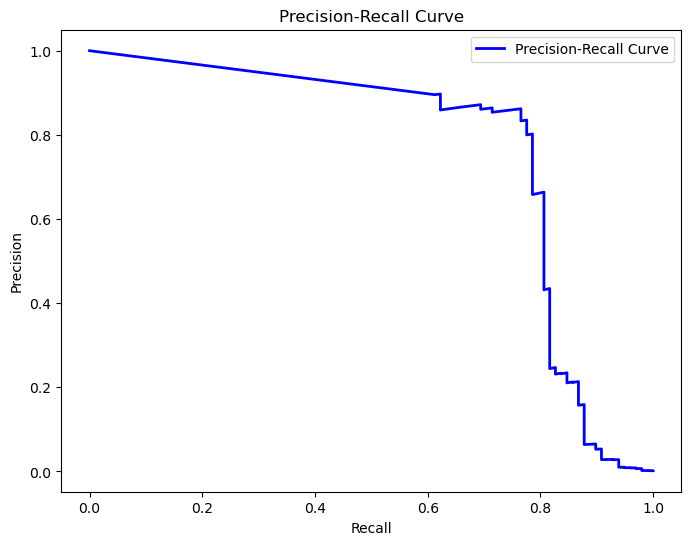

In [37]:
# Calculate precision and recall values at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

plt.show()

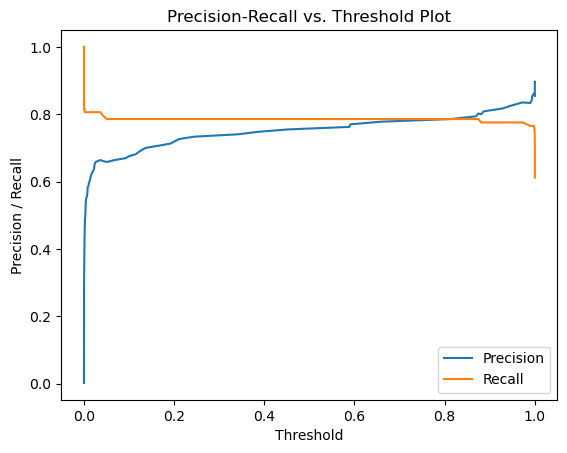

In [38]:
# Calculate precision and recall at different threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')

plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall vs. Threshold Plot')

plt.legend()


plt.show()

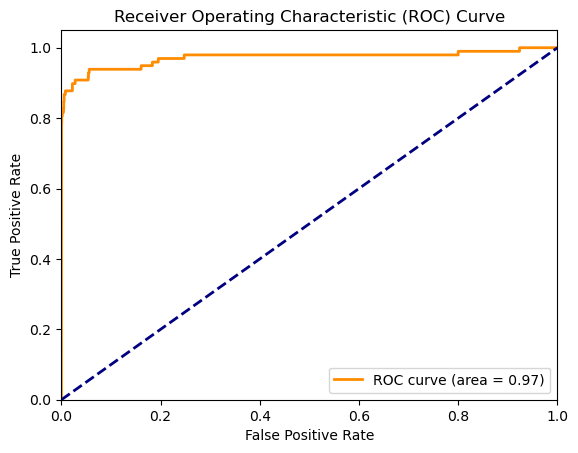

In [39]:
# Assuming y_test contains the true labels and y_pred_proba contains the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()